In [12]:
import numpy as np
from array import array
from os import stat
import matplotlib.pyplot as plt
import socket
import scipy.signal as signal

# Offline berechnung

# Signalaufbereitung
Im ersten Schritt muss die gespeicherte Sequenz geladen werden.
Zudem wird der DC Offset entfernt und das ganze Signal auf +-1 Normiert.

In [13]:
 # read in I/Q samples from binary file
filename = r"C:\Users\yanni\OneDrive\Documents\Hochschule\5.Semester\PAIND\loraShortShort.sig"
n_float32 = int(stat(filename).st_size/4)
with open(filename,"rb") as binary_file:
    arr = array('f')
    arr.fromfile(binary_file,n_float32)
rx = np.array(arr.tolist()[::2])+1j*np.array(arr.tolist()[1::2])
rx /= np.amax(np.abs(rx)) # normalize to 1
rx -= np.mean(rx)    # remove DC
print("signal size:",rx.shape[0])

signal size: 11090432


# Dastellung im Frequenzbereich
Um die Signale im Frequenzberich abbilden zu können, wird ein Spectrogramm benötigt, welche falblich die Signalsstärke anzeigt, sowie auf de nAchsen das Freqeunsspektrum und die Anzahl der Abtastungen

In [14]:
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

def analysis_DFTFB(x,w,fftlen,ts):
    # analysis FB
    # x      : input signal
    # w      : window
    # fftlen : FFT size, not exceeding the window length
    # ts     : downsampling factor, not exceeding the window length

    x_shape = x.shape
    y = np.reshape(x,(int(np.prod(x_shape[0:-1])),x_shape[-1]))
    n_symbols = int(np.ceil(x_shape[-1]/ts))
    z = np.zeros((int(np.prod(x_shape[0:-1])),n_symbols,fftlen),dtype=np.complex64)
    for i in range(y.shape[0]):
        yi = np.concatenate((y[i,:],np.zeros((ts-(x_shape[-1]%ts))%ts)))
        yi = yi.reshape((n_symbols,ts))
        wi = np.zeros((n_symbols,len(w)),dtype=np.complex64)
        for j in range(0,int(np.ceil(len(w)/ts))):
            i1 = np.minimum((j+1)*ts,len(w))
            wi[0:n_symbols-j,j*ts:i1] = np.tile(w[j*ts:i1],(n_symbols-j,1))*yi[j:,0:i1-j*ts]
        for j in range(1,int(np.ceil(len(w)/fftlen))):
            i1 = np.minimum((j+1)*fftlen,len(w))
            wi[:,0:i1-j*fftlen] = wi[:,0:i1-j*fftlen]+wi[:,j*fftlen:i1]
        z[i,:,:] = np.fft.fft(wi[:,0:fftlen])
    return z.reshape((x_shape[0:-1]+(n_symbols,fftlen)))

def display_spectrogram(x):
    fftlen = 512
    ts = 64
    w = np.sqrt(1/1536)*(1+np.cos(np.arange(-np.pi,np.pi,2*np.pi/fftlen)))/2

    z = 20*np.log10(np.abs(np.fft.fftshift(analysis_DFTFB(x,w,fftlen,ts),axes=1)))+1000
#       [Bug]: Colorbar does not work for negative values with contour/contourf #21882
    # display spectrum
    levels = MaxNLocator(nbins=15).tick_values(z.min(),z.max())
    cmap = plt.get_cmap('PiYG')
    norm = BoundaryNorm(levels,ncolors=cmap.N,clip=True)
    yp,xp = np.mgrid[slice(0,z.shape[0]),slice(0,z.shape[1])]
    fig = plt.figure()
    im = fig.gca().pcolormesh(xp,yp,z,cmap=cmap,norm=norm)
    fig.colorbar(im,ax=fig.gca())
    fig.gca().set_title('spectrogram')
    plt.show()

def display_spectrogram_if_signal(x,signal_strength):
    fftlen = 1024
    ts = 8
    w = np.sqrt(1/1536)*(1+np.cos(np.arange(-np.pi,np.pi,2*np.pi/fftlen)))/2

    z = 20*np.log10(np.abs(np.fft.fftshift(analysis_DFTFB(x,w,fftlen,ts),axes=1)))+1000
#       [Bug]: Colorbar does not work for negative values with contour/contourf #21882
    if(z.max() >= signal_strength):
        # display spectrum
        levels = MaxNLocator(nbins=15).tick_values(z.min(),z.max())
        cmap = plt.get_cmap('PiYG')
        norm = BoundaryNorm(levels,ncolors=cmap.N,clip=True)
        xp,yp = np.mgrid[slice(0,z.shape[0]),slice(0,z.shape[1])]               # yp,xp = np.mgrid[slice(0,z.shape[0]),slice(0,z.shape[1])]
        fig = plt.figure()
        im = fig.gca().pcolormesh(xp,yp,z,cmap=cmap,norm=norm)
        fig.colorbar(im,ax=fig.gca())
        fig.gca().set_title('spectrogram')
        plt.show()

# Downsamling
Um eine Spektrumreduktion von insgesammt 1.625MHz auf 125kHz zu ermglichen wird das Signal mit einerm Faktor von 13 reduziert.
In das praxis bedeutet dies, dass nur jedes 13. Sample weiterverwendet wird. Es handeld sich somit um ein Downsampling mit dem Faktor 13.
Somit werden alle 8 möglichen Frequenzbänder auf ein Frequenzband reduziert.

# Signaldetection
Um zu überprüfen, dass das Signal auch auf der Datei befindet, wird eine simple detection von starken Signalen verwedet.
Dies dient jedoch nur zum visuellen Darstellen des Signals

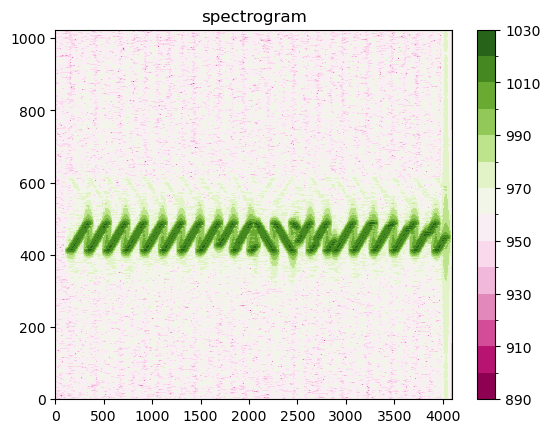

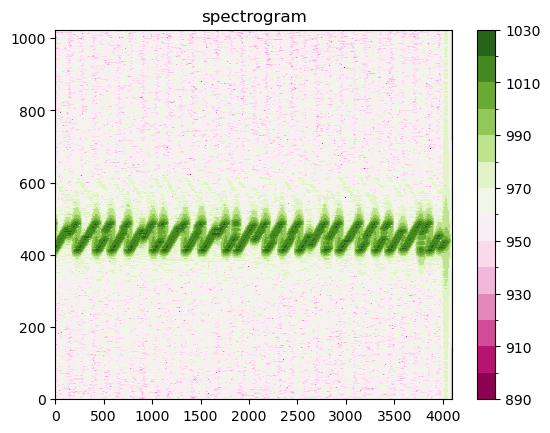

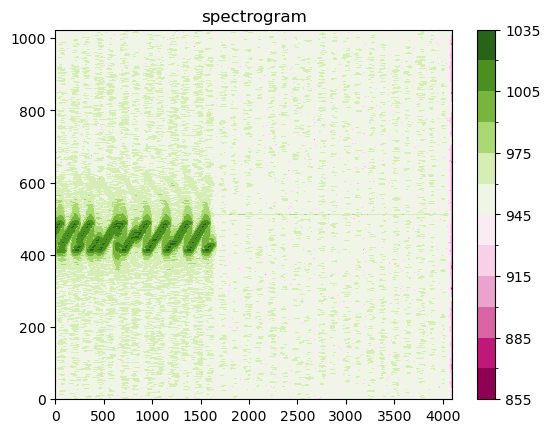

In [15]:
# Downsampling -> Überlagerung aller möglicher Frequenzbänder
rxd = rx
# rxd = signal.decimate(rx,10)
# rxd = signal.resample(rx,round(len(rx)/10),domain="time")
# rxd = rx[::13]
rxd = rxd[round(1.75*2**14):]
SIZE = 2**15
while (len(rxd)>(SIZE)):
    display_spectrogram_if_signal(rxd[:(SIZE)],1005)
    rxd = rxd[(SIZE):]



In [16]:
# loading Preambel
filename = r"C:\Users\yanni\OneDrive\Documents\Hochschule\5.Semester\PAIND\preamble.sig"
n_float32 = int(stat(filename).st_size/4)
with open(filename,"rb") as binary_file:
    pre = array('f')
    pre.fromfile(binary_file,n_float32)
pre = np.array(pre.tolist()[::2])+1j*np.array(pre.tolist()[1::2])
pre /= np.amax(np.abs(rx))      # normalize to 1
pre -= np.mean(rx)              # remove DC
print("signal size:",pre.shape[0])

signal size: 1568


# Referenzsignal
In einem externen Dokument können alle möglichen Symbole generiert werden. Diese werden dann benutzt, um diese mit dem augenommenen Signale zu vergleichen und übereitummungen zu erkennen.

In [17]:
# Starterkennung
import Preambel as pre
zero = pre.GetUpchirp(SF=7)
print(len(zero))

128


c:\Users\yanni\anaconda3\envs\PAIND\Lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


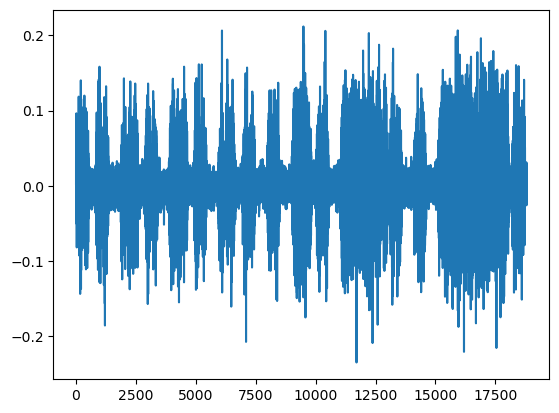

In [18]:
result = np.correlate(rxd,zero)
plt.plot(result)
plt.show()

In [19]:
dot = np.zeros(len(rxd))
while len(rxd) >= len(zero):
    dot[0:len(rxd)] = (np.dot(rxd[0:len(zero)],zero.T))
    rxd = rxd[len(zero):]
print("dot:", dot)
res = np.fft.fft(dot)
print("res:", res)

dot: [ 0.00554872  0.00554872  0.00554872 ... -0.01842789 -0.01842789
 -0.01842789]
res: [-1.24854947  +0.j         -1.52656324 -31.88738895j
 -6.27633343 -49.06430861j ... 64.01836657+104.36984921j
 -6.27633343 +49.06430861j -1.52656324 +31.88738895j]


C:\Users\yanni\AppData\Local\Temp\ipykernel_9724\1386663828.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  dot[0:len(rxd)] = (np.dot(rxd[0:len(zero)],zero.T))


In [20]:
dot = np.zeros(len(rxd))
for x in range(1, len(rxd)-1):
    dot[0:len(rxd)] = (np.dot(rxd[0:len(zero)],zero.T))
    

In [21]:
DEVEATION = 0.5
for x in range(3,len(res)):
    if abs(res[x-1] - res[x])< DEVEATION and abs(res[x-2] - res[x-1])< DEVEATION:
        print(f"at Position {x-2} - {x}, is the value {abs(res[x])}")

at Position 146 - 148, is the value 2.3737508795772433e-15
at Position 147 - 149, is the value 0.21427622629810583
at Position 148 - 150, is the value 0.6595895522171713
at Position 294 - 296, is the value 2.4756977713400195e-15
at Position 295 - 297, is the value 0.10753137986729318
at Position 296 - 298, is the value 0.3321090900711481
at Position 442 - 444, is the value 1.9860273225978185e-15
at Position 443 - 445, is the value 0.07180427755530192
at Position 444 - 446, is the value 0.22201453987827768
at Position 590 - 592, is the value 1.865207723429512e-15
at Position 591 - 593, is the value 0.05392145425806742
at Position 592 - 594, is the value 0.16681549304557147
at Position 593 - 595, is the value 0.6183445945478775
at Position 737 - 739, is the value 0.043307118803303665
at Position 738 - 740, is the value 1.790180836524724e-15
at Position 739 - 741, is the value 0.043190817066000614
at Position 740 - 742, is the value 0.13366350700503993
at Position 741 - 743, is the value 

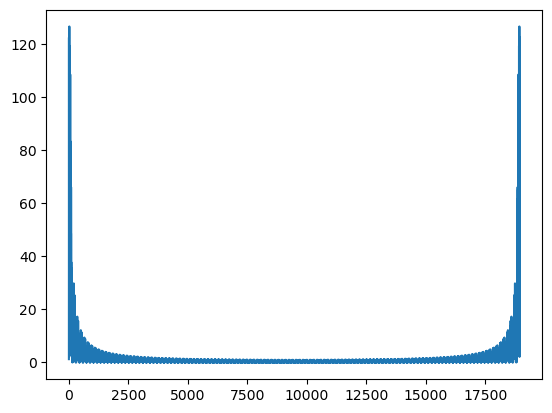

In [22]:
x = np.arange(len(res))
plt.plot(x,abs(res))
